 "La empresa Global Superstore tiene presencia mundial y un alto volumen de ventas, pero necesita identificar focos de ineficiencia financiera (fugas de dinero) y oportunidades de expansión estratégica para maximizar su beneficio neto."

In [64]:
#Inicialmente cargamos el dataset mediante pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("C:/Users/lucia/Downloads/archive/Global_Superstore2.csv", encoding="latin-1")
#https://raw.githubusercontent.com/NicoLencina95/ProyectoFinalDataScience/main/winequality-red.csv


In [65]:
#Una vez cargado el dataset, revisamos su estructura, tipos de datos y valores nulos
df.shape

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  str    
 2   Order Date      51290 non-null  str    
 3   Ship Date       51290 non-null  str    
 4   Ship Mode       51290 non-null  str    
 5   Customer ID     51290 non-null  str    
 6   Customer Name   51290 non-null  str    
 7   Segment         51290 non-null  str    
 8   City            51290 non-null  str    
 9   State           51290 non-null  str    
 10  Country         51290 non-null  str    
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  str    
 13  Region          51290 non-null  str    
 14  Product ID      51290 non-null  str    
 15  Category        51290 non-null  str    
 16  Sub-Category    51290 non-null  str    
 17  Product Name    51290 non-null  str    
 1

In [66]:
#chequeamos suma de nulos por columna
df.isnull().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

In [67]:
#Eliminación de columnas innecesarias por valores nulos (Postal Code no aporta información relevante ya que contamos con Región, Estado y Ciudad)
df.drop(columns=['Postal Code'], inplace=True)

In [68]:
#Revisamos tipos de datos por columna para detectar posibles inconsistencias
df.dtypes

Row ID              int64
Order ID              str
Order Date            str
Ship Date             str
Ship Mode             str
Customer ID           str
Customer Name         str
Segment               str
City                  str
State                 str
Country               str
Market                str
Region                str
Product ID            str
Category              str
Sub-Category          str
Product Name          str
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping Cost     float64
Order Priority        str
dtype: object

In [69]:
#Cambio de tipo de dato para la columna 'Order Date' y 'Ship Date' a tipo fecha
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d-%m-%Y')

In [70]:
#Agregamos una nueva columna de Unit Price para analizar el precio unitario de cada producto
df['Unit_Price'] = df['Sales'] / df['Quantity']
#Tambien desglozamos las fechas para obtener año y mes de cada orden, lo que nos permitirá analizar tendencias temporales en las ventas
df['Order_Year'] = df['Order Date'].dt.year
df['Order_Month'] = df['Order Date'].dt.month


In [71]:
#Clasificamos las columnas en numéricas , categóricas y fechas para facilitar su análisis posterior
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
date_cols = df.select_dtypes(include=['datetime64']).columns
print("Columnas numéricas:", numerical_cols)
print("Columnas categóricas:", categorical_cols)
print("Columnas de fecha:", date_cols)

Columnas numéricas: Index(['Row ID', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost',
       'Unit_Price'],
      dtype='str')
Columnas categóricas: Index(['Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment',
       'City', 'State', 'Country', 'Market', 'Region', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Order Priority'],
      dtype='str')
Columnas de fecha: Index(['Order Date', 'Ship Date'], dtype='str')


C:\Users\lucia\AppData\Local\Temp\ipykernel_19928\59158012.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include=['object']).columns


In [72]:


#Chequear valores imposibles o inconsistentes

def dq_score(df):
    impossible_values = {
        'Quantity': df[df['Quantity'] < 0].shape[0],
        'Sales': df[df['Sales'] < 0].shape[0],
        'Unit_Price': df[df['Unit_Price'] < 0].shape[0],
        'Discount': df[df['Discount'] < 0].shape[0],
        'Profit': df[df['Profit'] < 0].shape[0]}  
    total_impossible = sum(impossible_values.values())
    total_rows = df.shape[0]
    dq_score = 100 - (total_impossible / total_rows * 100)
    return dq_score, impossible_values  
dq_score_value, impossible_values = dq_score(df)
print(f"DQ Score: {dq_score_value:.2f}%")
print("Valores imposibles encontrados:")
for column, count in impossible_values.items():
    print(f"{column}: {count}")

DQ Score: 75.54%
Valores imposibles encontrados:
Quantity: 0
Sales: 0
Unit_Price: 0
Discount: 0
Profit: 12544


Como vemos, tenemos valores de profit negativos pero eso es común en el mercado ya que a veces es necesario seguir dentro de ciertos mercados
aunque conlleve pérdidas. Estar dentro de esos mercados le aporta a la empresa valores o consideraciones más importantes que el dinero.
Los demás valores estan bien

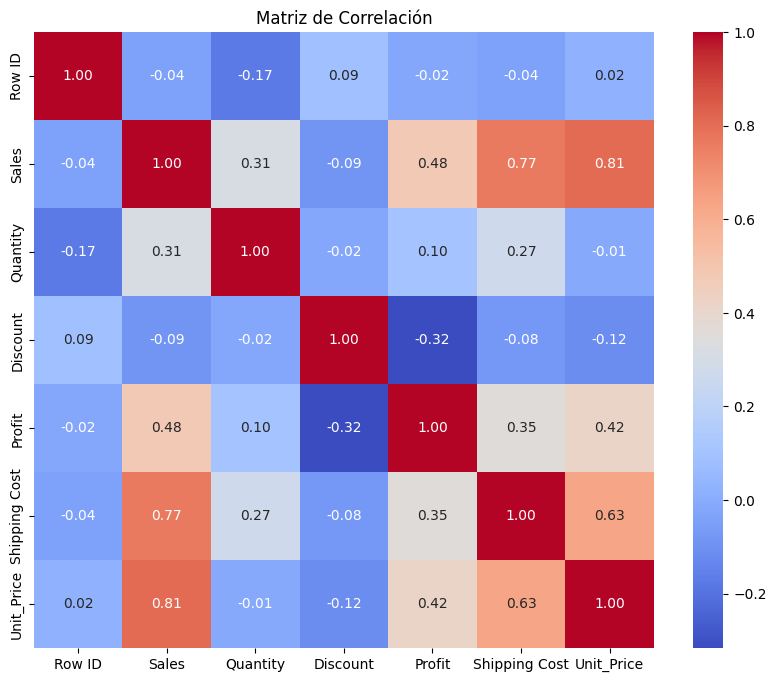

In [73]:
#Correlación entre variables numéricas
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Considerando las relaciones entre los campos podemos empezar a obtener información valiosa sobre el mercado a nivel mundial.

Hipótesis: La política de descuentos agresivos está disminuyendo el margen de ganancia en ciertas regiones sin generar un aumento proporcional en el volumen de ventas.
Preguntas a responder:

        ¿Cuál es la correlación entre el nivel de “Discount” y el “Profit”?

        ¿Existe un "punto de quiebre" (ej: más del 20% de descuento) donde la venta siempre resulta en pérdida?

        ¿Qué categorías de productos sufren más por los descuentos excesivos?


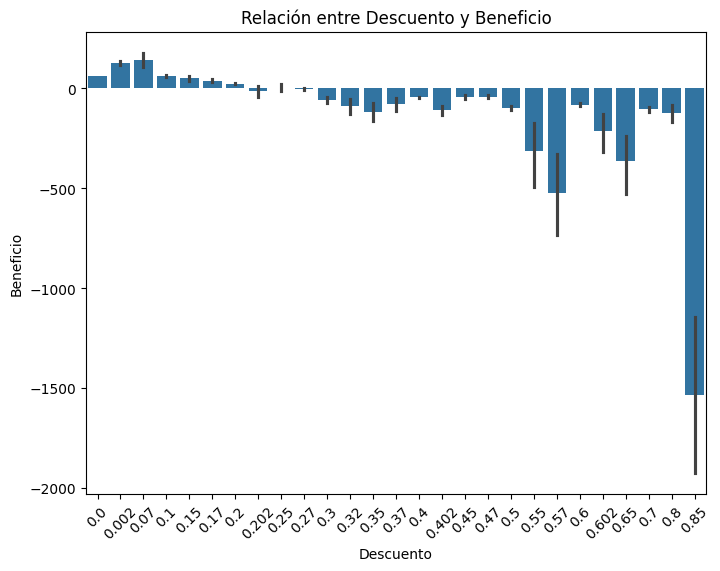

In [74]:
#Correlación entre Discount y Profit por gráfico de barras 

plt.figure(figsize=(8, 6))
sns.barplot(x='Discount', y='Profit', data=df)  
plt.title('Relación entre Descuento y Beneficio')
plt.xlabel('Descuento')
plt.ylabel('Beneficio')
plt.xticks(rotation=45)
plt.show()

Como podemos observar existe una correlación negativa entre el beneficio de las ventas (Profit) y los descuentos ofrecidos (Discount) aunque dentro del rango 0 a 20% se mantiene positiva. Es necesario desglozar entre productos para tener un  valor más acertado de qué descuentos generan mayores beneficios
A partir de este gráfico podemos notar claramente que descuentos mayores a 20% generan pérdida en el mercado por lo que no es aconsejable superar este valor

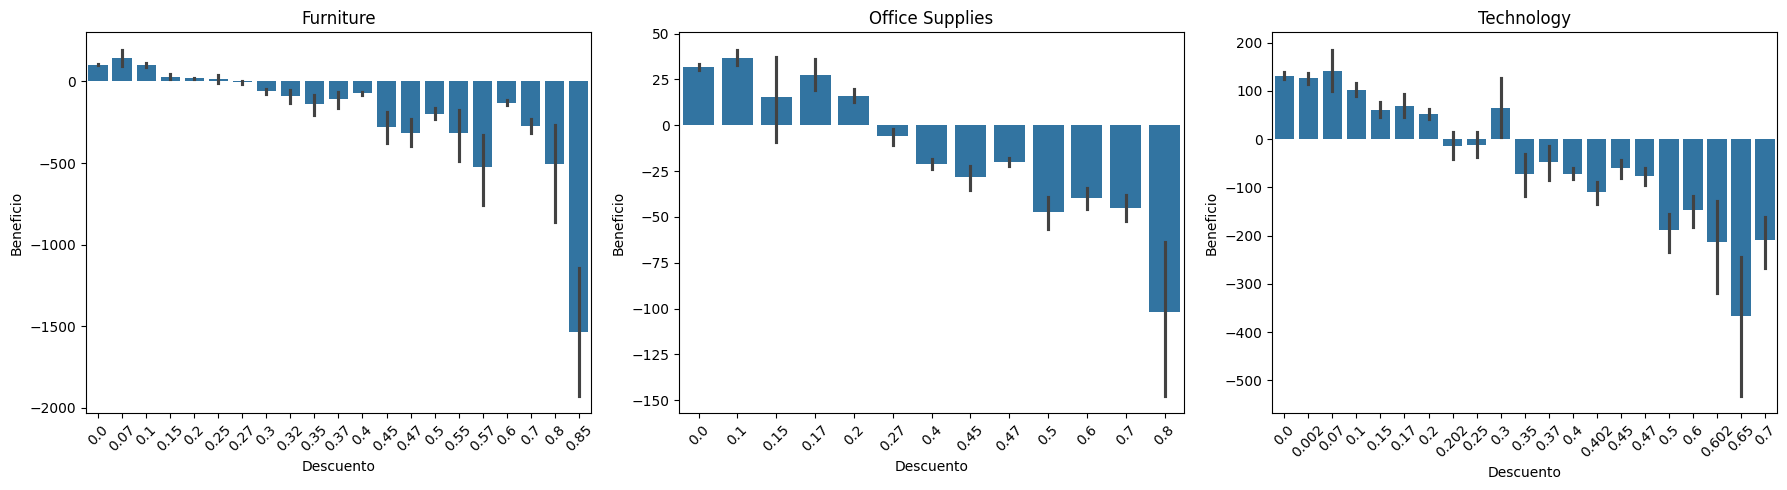

In [75]:
#Categorias que se ven más afectadas por los descuentos en términos de beneficio
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Discount', y='Profit', data=df[df['Category'] == 'Furniture'])
plt.title('Furniture')
plt.xlabel('Descuento')
plt.ylabel('Beneficio')
plt.xticks(rotation=45) 
plt.subplot(1, 3, 2)
sns.barplot(x='Discount', y='Profit', data=df[df['Category'] == 'Office Supplies'])
plt.title('Office Supplies')
plt.xlabel('Descuento')
plt.ylabel('Beneficio')
plt.xticks(rotation=45)
plt.subplot(1, 3, 3)
sns.barplot(x='Discount', y='Profit', data=df[df['Category'] == 'Technology'])
plt.title('Technology')
plt.xlabel('Descuento')
plt.ylabel('Beneficio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Como podemos observar, la categoría Furniture (Muebles) es la más afectada por los descuentos. Habría que analizar si el costo de shipping es demasiado costoso para cubrir el beneficio de la compra.

En conclusión a estas 3 preguntas:
-La relación de Beneficio y Descuentos es negativa aunque si se ajusta el rango hasta 20% de descuento es productiva obteniendose beneficios y atracción sobre el mercado, siendo el mayor beneficio cercano al 10% de descuento.
-Descuentos mayores al 20% generan pérdidas en el mercado.
-La categoría de productos más afectada por los descuentos es la de Furniture (Muebles)


    Hipótesis: Ciertas subcategorías de productos (probablemente las más pesadas o voluminosas) son logísticamente ineficientes y generan pérdidas sistemáticas.
    Preguntas:
    ¿Relación entre Sub-Categorías y Profit?
    ¿Cuáles son las 3 subcategorías más rentables y las 3 menos rentables (o con pérdidas)?
    ¿Se mantiene la regla de Pareto (80/20)? (¿El 20% de los productos generan el 80% de las ganancias?)
    ¿La categoría ‘Technology’ tiene mejor margen que ‘Furniture’?


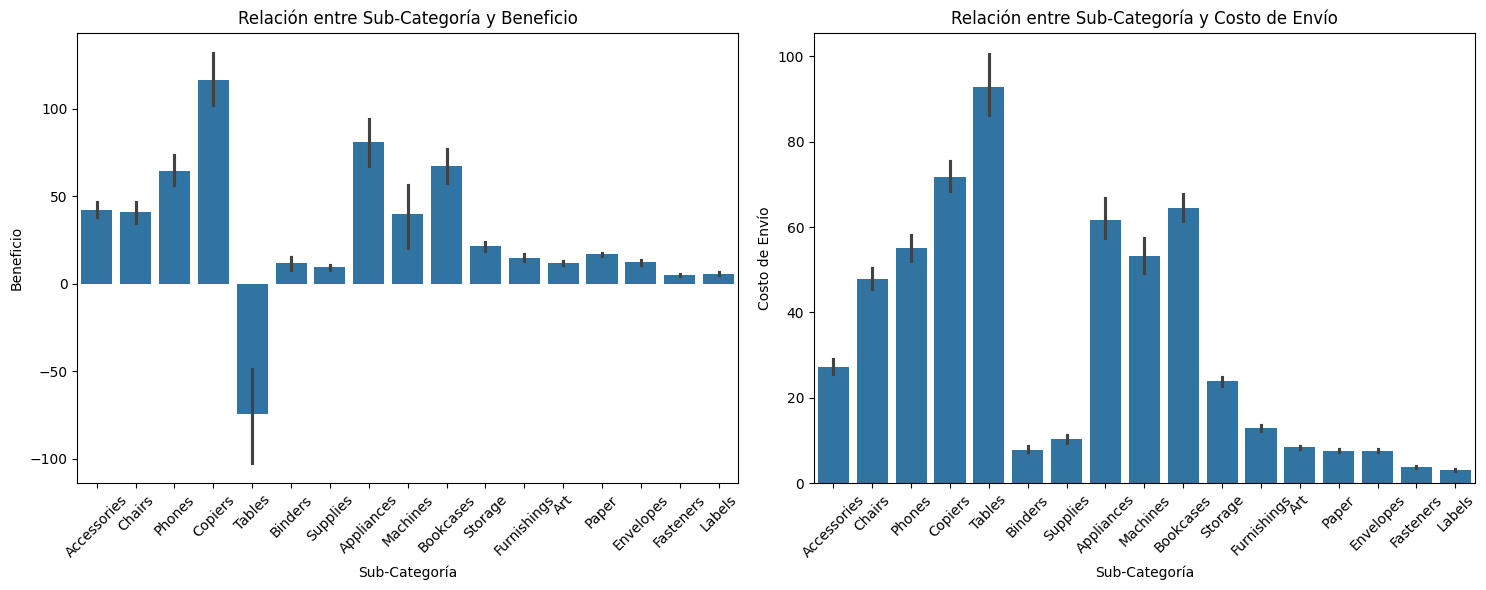

In [76]:
#Correlación entre sub categorias y profit por gráfico de barras
#Correlacion entre Shipping Costo y Subcategoria por gráfico de barras
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Sub-Category', y='Profit', data=df)
plt.title('Relación entre Sub-Categoría y Beneficio')
plt.xlabel('Sub-Categoría')
plt.ylabel('Beneficio')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.barplot(x='Sub-Category', y='Shipping Cost', data=df)
plt.title('Relación entre Sub-Categoría y Costo de Envío')
plt.xlabel('Sub-Categoría')
plt.ylabel('Costo de Envío')
plt.xticks(rotation=45)
plt.tight_layout()


Observando el gráfico, podemos ver que efectivamente una de las Sub-Categorías de productos más pesados termina generando pérdidas en lugar de beneficios y al observar los costos de envío claramente es una Sub-Categoría muy costosa logisticamente.

Respecto a la siguiente pregunta, los sujetadores, etiquetas y carpetas (Fasteners, Labels y Binders respectivamente) son los productos que generan menor beneficio en cuanto a ventas. Por el otro lado, las Estanterías, Accesorios y Copiadoras (Bookcases, Appliances y Copiers respectivamente) son las más productivas en cuanto a beneficio, siendo la última la mejor por casi el doble de beneficio frente a las demás.

Hipótesis: Existen mercados específicos donde los costos operativos (o de envío) superan los ingresos, haciendo que la presencia en esos países sea insostenible.

    Preguntas a responder:

        ¿Qué países tienen Ventas (Sales) altas, pero Ganancia (Profit) negativa? (El problema de "vender mucho y perder dinero").

        ¿Qué Market es el más rentable en términos absolutos y cuál en términos relativos (margen)?

        ¿Cómo varían los costos de envío (Shipping Cost) por región? ¿Son desproporcionados en algún continente?


In [77]:




# 2. Agrupar por 'Market' y sumar Ventas y Ganancias
rentabilidad_mercado = df.groupby('Market')[['Sales', 'Profit']].sum()

# 3. Calcular el Margen Relativo (Profit / Sales)
# Multiplicamos por 100 para tener el porcentaje
rentabilidad_mercado['Margin_Percent'] = (rentabilidad_mercado['Profit'] / rentabilidad_mercado['Sales']) * 100

# 4. Ordenar para encontrar los ganadores
# Más rentable en términos absolutos (Dinero total)
top_absoluto = rentabilidad_mercado.sort_values('Profit', ascending=False).head(1)

# Más rentable en términos relativos (Eficiencia/Margen)
top_relativo = rentabilidad_mercado.sort_values('Margin_Percent', ascending=False).head(1)

# 5. Mostrar resultados
print("--- Rentabilidad por Mercado ---\n")
print(rentabilidad_mercado.sort_values('Profit', ascending=False))

print(f"\nGanador Absoluto (Más dinero generado): {top_absoluto.index[0]} con ${top_absoluto['Profit'].values[0]:,.2f}")
print(f"Ganador Relativo (Mejor margen): {top_relativo.index[0]} con {top_relativo['Margin_Percent'].values[0]:.2f}%")

--- Rentabilidad por Mercado ---

               Sales        Profit  Margin_Percent
Market                                            
APAC    3.585744e+06  436000.04900       12.159263
EU      2.938089e+06  372829.74150       12.689532
US      2.297201e+06  286397.02170       12.467217
LATAM   2.164605e+06  221643.48708       10.239442
Africa  7.837732e+05   88871.63100       11.338947
EMEA    8.061613e+05   43897.97100        5.445309
Canada  6.692817e+04   17817.39000       26.621660

Ganador Absoluto (Más dinero generado): APAC con $436,000.05
Ganador Relativo (Mejor margen): Canada con 26.62%


In [78]:

# 1. Agrupar por País y sumar métricas
analisis_pais = df.groupby('Country')[['Sales', 'Profit']].sum()

# 2. Filtrar: Nos quedamos solo con los que tienen Ganancia NEGATIVA
paises_con_perdidas = analisis_pais[analisis_pais['Profit'] < 0]

# 3. Ordenar: De mayor a menor VENTA
# Esto es clave: queremos ver primero los países donde facturamos millones pero perdemos dinero.
top_problemas = paises_con_perdidas.sort_values('Sales', ascending=False)

# 4. Mostrar resultados
print("--- Países con 'Fugas de Dinero' (Ventas Altas / Profit Negativo) ---")
print(top_problemas.head(10)) # Mostramos los 10 casos más graves

--- Países con 'Fugas de Dinero' (Ventas Altas / Profit Negativo) ---
                           Sales       Profit
Country                                      
Philippines         183420.16500 -16128.22500
Dominican Republic  126140.58128  -7613.49872
Turkey              108507.94800 -98447.23200
Honduras             90125.64860 -29482.37140
Netherlands          77514.94500 -41070.07500
Thailand             77051.95500  -7308.19500
Vietnam              65800.19940  -1870.23060
Pakistan             58872.61200 -22446.64800
Argentina            57511.78328 -18693.79672
Nigeria              54350.35200 -80750.71800


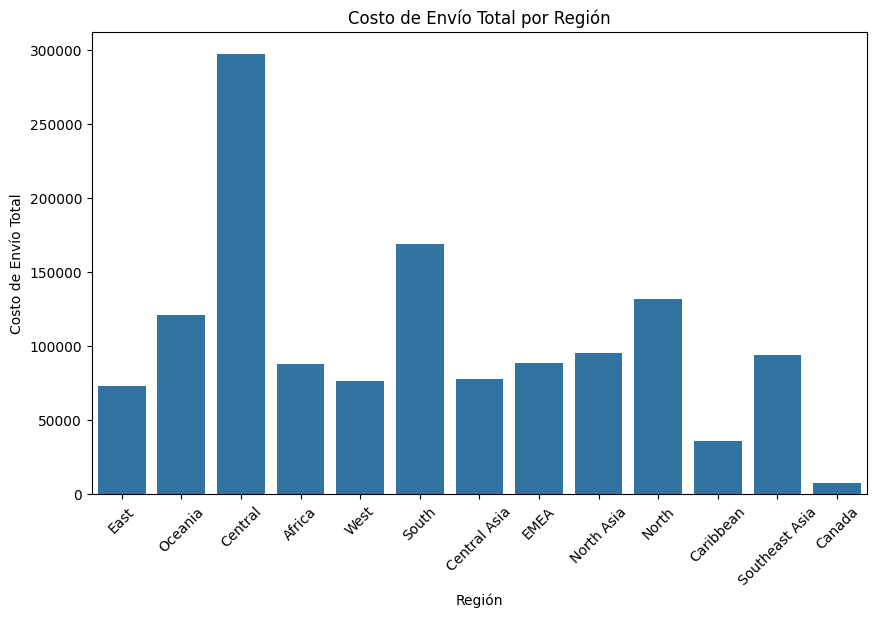

In [80]:
#Grafico de como varian los shipping cost por region
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Shipping Cost', data=df, estimator=sum, errorbar=None)
plt.title('Costo de Envío Total por Región')
plt.xlabel('Región')
plt.ylabel('Costo de Envío Total')
plt.xticks(rotation=45)
plt.show()

In [81]:
#Paises dentro de la region Central en forma de tabla
paises_central = df[df['Region'] == 'Central']['Country'].unique()
print("Países en la región Central:")
print(paises_central)


Países en la región Central:
<StringArray>
[      'Germany',        'France', 'United States',   'El Salvador',
     'Nicaragua',       'Austria',   'Netherlands',     'Guatemala',
       'Belgium',   'Switzerland',      'Honduras',        'Panama']
Length: 12, dtype: str


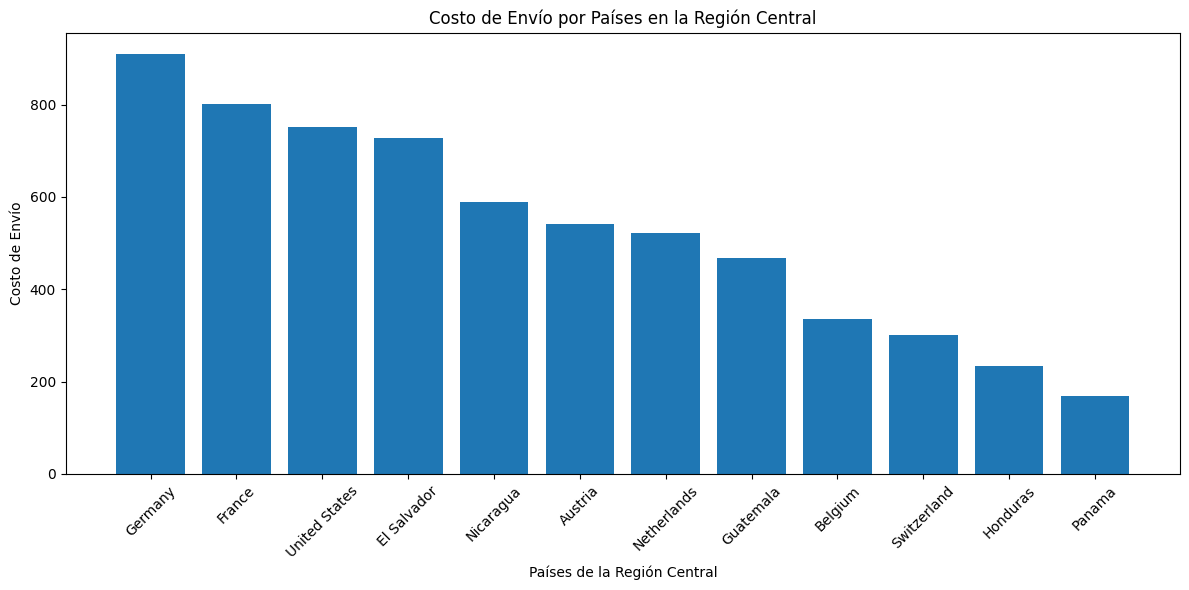

In [82]:
#GRafico de Shipping Cost por paises de la region Central
plt.figure(figsize=(12, 6))
df_central = df[df['Region'] == 'Central']
plt.bar(df_central['Country'], df_central['Shipping Cost'])
plt.xlabel('Países de la Región Central')
plt.ylabel('Costo de Envío')
plt.title('Costo de Envío por Países en la Región Central')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    Hipótesis: El segmento corporativo es más estable y rentable, mientras que el consumidor final es más sensible al precio y requiere más descuentos.

    Preguntas a responder:

        ¿Qué segmento de cliente aporta mayor ganancia promedio por orden?

        ¿Cómo es la frecuencia de compra y el valor monetario (RFM simplificado) entre los diferentes segmentos?

        ¿Quiénes son los "Top Customers" que debemos cuidar?


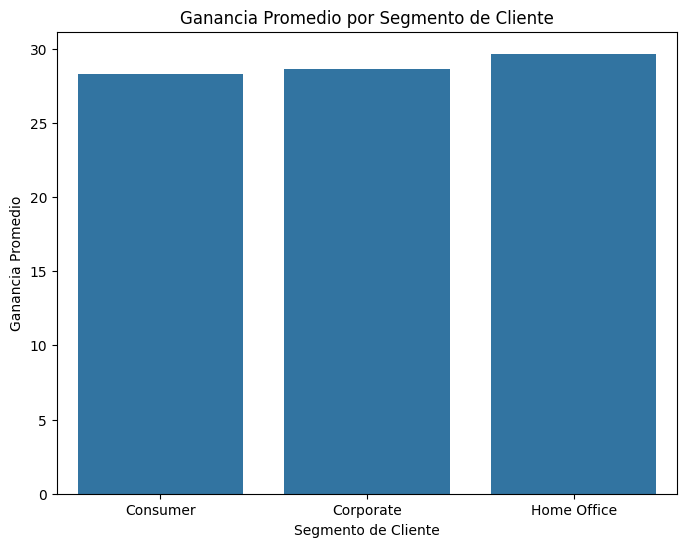

In [84]:
#Qué segmento de cliente aporta mayor ganancia promedio por orden por grafico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Segment', y='Profit', data=df, estimator='mean', errorbar=None)
plt.title('Ganancia Promedio por Segmento de Cliente')
plt.xlabel('Segmento de Cliente')
plt.ylabel('Ganancia Promedio')
plt.show()


In [85]:


# 1. Definimos una función para calcular RFM
def calcular_rfm(df, col_cliente, col_fecha, col_orden, col_monto, col_segmento):
    
    # Fecha de referencia: El día siguiente a la última venta registrada
    fecha_maxima = df[col_fecha].max() + pd.Timedelta(days=1)
    
    # Agrupamos por Cliente para calcular sus métricas individuales
    rfm_clientes = df.groupby(col_cliente).agg({
        col_fecha: lambda x: (fecha_maxima - x.max()).days, # Recencia: Días desde la última compra
        col_orden: 'nunique',                               # Frecuencia: Cantidad de compras únicas
        col_monto: 'sum',                                   # Valor Monetario: Total gastado
        col_segmento: 'first'                               # Segmento al que pertenece
    }).reset_index()
    
    # Renombramos para que sea legible
    rfm_clientes.columns = ['Cliente_ID', 'Recencia_Dias', 'Frecuencia', 'Valor_Total', 'Segmento']
    
    return rfm_clientes

# 2. Ejecutamos el cálculo con tus datos
# Usamos 'Region' como segmento, ya que es lo que tenemos disponible
df_rfm = calcular_rfm(
    df,                # Tu dataframe limpio
    col_cliente='Customer ID',  # ID del cliente
    col_fecha='Order Date',  # Fecha de la compra
    col_orden='Order ID',    # ID de la orden (para contar cuántas veces vino)
    col_monto='Sales',     # Dinero gastado
    col_segmento='Region'       # Variable de agrupación
)

# 3. Resumen por Segmento (Promedios)
rfm_resumen = df_rfm.groupby('Segmento')[['Recencia_Dias', 'Frecuencia', 'Valor_Total']].mean().round(2)

print("--- Análisis RFM por Región (Promedios por Cliente) ---")
print(rfm_resumen.sort_values('Valor_Total', ascending=False))

--- Análisis RFM por Región (Promedios por Cliente) ---
                Recencia_Dias  Frecuencia  Valor_Total
Segmento                                              
East                    27.11       26.80     14503.81
Central Asia            28.56       25.35     14493.20
North Asia              31.33       26.23     14165.82
West                    26.10       26.25     13959.23
Central                 33.15       25.90     13793.37
Caribbean               22.15       25.80     13786.36
South                   30.74       27.07     13727.41
Southeast Asia          29.34       25.21     13700.30
North                   26.51       26.41     13369.98
Oceania                 28.18       25.17     13229.41
Africa                 139.66        6.24      2139.57
EMEA                   143.93        6.48      2049.52
Canada                 133.26        5.97      1920.19


In [92]:
#Calculo para identificar el top 10 de clientes más valiosos (mayor Sales) y su segmento
top_clientes = df_rfm.sort_values('Valor_Total', ascending=False).head(10)
print("\n--- Top 10 Clientes Más Valiosos ---")
print(top_clientes[['Cliente_ID', 'Valor_Total', 'Segmento']])



--- Top 10 Clientes Más Valiosos ---
     Cliente_ID  Valor_Total   Segmento
1463   TA-21385  35668.12080       East
623    GT-14710  34471.89028      North
1489   TC-20980  34218.26900    Central
1405   SM-20320  31125.29496  Caribbean
237    BW-11110  30613.61650    Central
656    HL-15040  29664.23058    Oceania
1369   SE-20110  29532.62502    Central
1220   PS-19045  29252.31940      South
1243   RB-19360  29197.63460    Oceania
1587   ZC-21910  28472.81926    Central


Dentro del TOP 10 de Clientes, hay 4 que se encuentran en la region central, zona que tiene los mayores costos de shipping. Si queremos mantener esos clientes sería adecuado favorecerlos con costos de envío promocionales a fines de incentivar sus compras.

In [ ]:
'''Mapping 2:19:00(Unidad 5) Sirve para taggear datos y poder crear nuevos campos para enriquecer el dataset
por ej: definir valores de ventas bajas,m
edias o altas según parámetros propios

2:24:00 (Unidad 5 10/01)
Segmentaciones a través del group by

2:32:00 group by para obtener el top products

2:38:00 explica un def para aplicar tiquets de mapping

2:43:00 tabla pivot para chequeo de group bys'''


df.shape
df.columns
df.info()
df.unique().sort_values(ascending=True)
#Normalización de strings a minúsculas con primero letra mayúscula
for col in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category', 'Product Name', 'Customer Name', 'Order Priority']:
    df[col] = df[col].str.lower().str.title()
#En el video de la unidad 6 17-01 se muestra como hacer un cuadro de nulos bastante didactico 1:03:00

#revisar outliers
import matplotlib.pyplot as plt
import seaborn as sns   
sns.boxplot(x=df['Sales'])
plt.show()

#Dividir fechas en día, mes y año
df['Order Day'] = df['Order Date'].dt.day
df['Order Month'] = df['Order Date'].dt.month
df['Order Year'] = df['Order Date'].dt.year

#KPI de precio neto unitario
df['Net Unit Price'] = df['Sales'] / df['Quantity']
#KPI de costo unitario
df['Unit Cost'] = df['Profit'] / df['Quantity']
#KPI de margen de beneficio unitario
df['Unit Profit Margin'] = df['Net Unit Price'] - df['Unit Cost']
#KPI de margen de beneficio porcentual
df['Unit Profit Margin Percentage'] = (df['Unit Profit Margin'] / df['Net Unit Price']) * 100

#Realizar un dq score para evaluar la calidad de los datos 3:44:00 Unidad 5 10-01
def dq_score(df):


#Chequear valores imposibles o inconsistentes
    impossible_values = {
        'Quantity': df[df['Quantity'] < 0].shape[0],
        'Sales': df[df['Sales'] < 0].shape[0],
        'Profit': df[df['Profit'] < 0].shape[0],
        'Net Unit Price': df[df['Net Unit Price'] < 0].shape[0],
        'Unit Cost': df[df['Unit Cost'] < 0].shape[0],
        'Unit Profit Margin': df[df['Unit Profit Margin'] < 0].shape[0],
        'Unit Profit Margin Percentage': df[df['Unit Profit Margin Percentage'] < 0].shape[0]
    }  
    total_impossible = sum(impossible_values.values())
    total_rows = df.shape[0]
    dq_score = 100 - (total_impossible / total_rows * 100)
    return dq_score, impossible_values  
dq_score_value, impossible_values = dq_score(df)
print(f"DQ Score: {dq_score_value:.2f}%")
print("Valores imposibles encontrados:")
for column, count in impossible_values.items():
    print(f"{column}: {count}")
     

# En la unidad 6 17-01 1:07:00 muestra una formma de heuristica que demuestra como son identificadas las columnas 

#Que producto factura más por region Unidad 6 1:15:00

#Sería clave evaluar si hubo aumento de precios en algún producto y si esto afecto la cantidad de ventas

#Realizar un RFM de los clientes para segmentarlos según su comportamiento de compra
#R=Recencia: tiempo desde la última compra
#F=Frecuencia: número de compras realizadas
#M=Monetario: gasto total realizado por el cliente
#tambien se puede hacer un RFM con productos o regiones en lugar de clientes
#Graficos
'''Ventas totales en el tiempo
Ventas por categoría de producto
    Ventas por región
    '''

#Antes de eliminar outliers se puede hacer gráficos para ver si realmente lo son 
#Hacer capping de outliers para limitar su impacto en el análisis 1:23:00 Unidad 8 31-01

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Market', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'Order Priority'],
      dtype='object')